In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np

**Torch, Numpy stuff**

In [171]:
if False:#torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cpu


---
**Training Data**

Demonstration data contains a list of **d** scenes:

- ~~Each scene contains a list of trajectories of **p** people, where p is **not constant**~~
- A trajectory is a list of **t** states, where t = 400
- A state is a **s** = 4 dimensional variable
 - State = (d<sub>goal<sub>x</sub></sub>, d<sub>goal<sub>y</sub></sub>, v<sub>x</sub>, v<sub>y</sub>)
    
> Shape of data is (d, ~~p,~~ t, s) => (d, ~~p,~~ 400, 4)

---

Train, test, val split: 0.8, 0.01, 0.19

In [172]:
from sklearn.model_selection import train_test_split

def data_from_demonstrations(obs_dims=[0,1], tar_dims=[2,3], path="../data/input/"):
    data = np.load(f"{path}/states_processed.npy")
    X, Y = data[:,:,:,obs_dims], data[:,:,:,tar_dims]
    return X, Y


# for testing purposes
def synthetic_data(n=10):
    tlen = 400
    X = np.zeros((n, tlen, 1))
    Y = np.zeros((n, tlen, 1))
    for i in range(n):
        X[i] = np.random.uniform(0, 1, tlen).reshape(tlen, 1)
        Y[i] = np.sin(X[i]*2*np.pi)/n + i/n
    return X, Y

#X, Y = data_from_demonstrations()
X, Y = synthetic_data()

X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8)

# 0.2 * 0.05 = 0.01 (test size in entire data)
test_sz = 0.05
X_val, X_test, Y_val, Y_test = train_test_split(X_rem, Y_rem, test_size=test_sz)

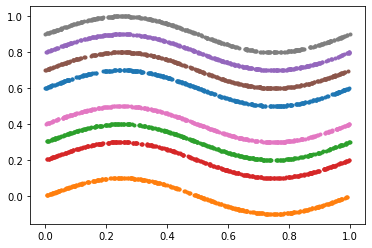

In [173]:
import matplotlib.pyplot as plt

def plot_trajectories(X, Y):
    d, t, s = X.shape
    for i in range(d):
        plt.plot(X[i], Y[i], ".")


plot_trajectories(X_train, Y_train)

---

### Preparing the data

**n <= n<sub>max</sub>** random number of random observations on a random trajectory

**get image**

In [174]:
from PIL import Image
import torchvision.transforms as T

def get_frames(path, demonstration_id, observation_ids):
    frames_path = f'{path}{demonstration_id}/'
    # transform = T.Compose([T.CenterCrop(256), T.Resize(128), T.Grayscale(), T.ToTensor()])
#     images = torch.stack((transform(Image.open('svn_.jpg')), 
#                           transform(Image.open('svn.jpg'))),  dim=0)

    transform = T.Compose([T.ToTensor()])

    frames = transform(Image.open(f"{frames_path}{observation_ids[0]}.jpg"))

    for i in observation_ids[1:]:
        frames = torch.stack((images, transform(Image.open(f"{frames_path}{observation_ids[i]}.jpg"))), dim=0)
    print(frames.shape)
    return frames

In [175]:
n_max = 10
d_size = 10000  # nof demonstrations
t_size = 400  # length of trajectories
path="../data/processed/input/"

def sample_training_demonstration():
#     d, t, s = X_train.shape
    
    rand_traj_ind = np.random.randint(0, d_size)
    n = np.random.randint(1, n_max+1)
#    rand_traj = X_train[rand_traj_ind]
#     rand_out = Y_train[rand_traj_ind]

    rand_traj = np.load(f"{path}{rand_traj_ind}.npy")

    observation_indices = np.random.choice(np.arange(t_size), n+1, replace=False) # n+1: +1 is for sampling the target
    
    frames = get_frames(path, rand_traj_ind, observation_indices)
    
    observations = torch.from_numpy(rand_traj[observation_indices[:-1], :])
    targetX = torch.from_numpy(rand_traj[observation_indices[-1], 0:2])
    targetY = torch.from_numpy(rand_out[observation_indices[-1], 2:])
    
    return frames, observations, targetX, targetY

---
### Model

In [176]:
class CNP(nn.Module):
    def __init__(self):
        super(CNP, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 4, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4, 8, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.encoder = nn.Sequential(
            nn.Linear(4+32*4*4,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,1024)
        )
        
        self.query = nn.Sequential(
            nn.Linear(1024+2,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,2*2)
        )

    def forward(self, frames, observations, target):
        # n < n_max frames of a scene along with momentary observations are concatenated to constitute input
        scene_encodings = torch.flatten(self.cnn(frames))
        scene_encodings = self.cnn(frames).view(frames.shape[0], 32*4*4)
        encoder_in = torch.cat((observations, scene_encodings), 1)
        r = self.encoder(encoder_in)
        
        r_avg = torch.mean(r, dim=0)
        r_avgs = r_avg.repeat(target.shape[0], 1)  # repeating the same r_avg for each target
        
        r_avg_target = torch.cat((r_avgs, target), 1)
        query_out = self.query(r_avg_target)
        
        return query_out

    
def log_prob_loss(output, target):
    mean, sigma = output.chunk(2, dim = -1)
    sigma = F.softplus(sigma)
    dist = D.Independent(D.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

In [177]:
model = CNP()
model.to(device)

optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

epoch = 1000
for i in range(epoch):
    fs, obss, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_pred = model(fs, obss, tx)
    loss = log_prob_loss(ty, ty_pred)
    
    loss.backward()
    optimizer.step()
    
    print(loss)
    
#     enc = model(images, torch.rand(2, 4), torch.rand(2, 2))
#     print(enc.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/input/9379.npy'